In [2]:
# 安装依赖包（首次运行需取消注释）
!pip install requests beautifulsoup4 lxml pandas numpy matplotlib scikit-learn tensorflow akshare jieba

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import jieba
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import akshare as ak
import datetime
from lxml import etree
import time

In [46]:
#爬取东方财富股吧-宁德时代论坛评论内容
# !pip install requests pandas openpyxl

import requests, time, random
import pandas as pd

# 1. 配置
max_page   = 30
stock_code = '300750'    # 只写数字：宁德时代
base_url   = 'https://guba.eastmoney.com/api/getData'
headers = {
    'User-Agent': (
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) '
        'AppleWebKit/537.36 (KHTML, like Gecko) '
        'Chrome/117.0.0.0 Safari/537.36'
    ),
    'Referer': f'https://guba.eastmoney.com/list,{stock_code},f.html'
}

all_titles = []
all_times  = []

# 2. 循环分页调用接口
for page in range(1, max_page+1):
    print(f'▶ Fetching page {page}')
    params = {
        'code': stock_code,
        # 注意：path 必须和你在 DevTools 里看到的一模一样
        'path': f'webarticlelist/api/guba/gubalist?page={page}&ps=50'
    }
    resp = requests.get(base_url, params=params, headers=headers, timeout=10)
    data = resp.json().get('data', {}).get('list', [])
    if not data:
        print('   — no more data, stopping')
        break

    for it in data:
        # F14 是标题，F18 是发布时间
        title = it.get('F14','').strip()
        ttime = it.get('F18','').strip()
        if title:
            all_titles.append(title)
            all_times.append(ttime)

    time.sleep(random.uniform(0.5, 1.5))

# 3. 保存到 Excel
df = pd.DataFrame({'title': all_titles, 'time': all_times})
df.to_excel('data_raw.xlsx', index=False)
print(f"✅ 共抓取 {len(df)} 条评论，已保存 data_raw.xlsx")

▶ Fetching page 1
   — no more data, stopping
✅ 共抓取 0 条评论，已保存 data_raw.xlsx


In [50]:
import requests, json

headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/117.0.0.0 Safari/537.36",
    "Referer": "https://guba.eastmoney.com/list,300750,f.html"
}

# —— 关键在这里，把 path 改成 list —— 
params = {
    "code": "300750",
    "path": "webarticlelist/api/guba/list?page=1&ps=50"
}

resp = requests.get(
    "https://guba.eastmoney.com/api/getData",
    params=params,
    headers=headers,
    timeout=10
)
resp.encoding = 'utf-8'

print("状态码:", resp.status_code)
print("前500字符:\n", resp.text[:500])

# 看看它是不是纯 JSON，如果是 JSONP 再 strip 一下 callback
try:
    data = resp.json()
except:
    # 去掉 callback( … )
    inner = json.loads(resp.text.split('(',1)[1].rsplit(')',1)[0])
    data = inner

print("顶层 keys:", data.keys())
# 常见在 data['data']['list']
lst = data.get("data",{}).get("list",[])
print("list 长度:", len(lst))
if lst:
    print("第一条字典 keys:", list(lst[0].keys()))

状态码: 200
前500字符:
 {"re":true,"result":[{"security":"1$600111$12050879181666","star":false},{"security":"0$002610$46634116412346","star":false},{"security":"1$600010$42453206952155","star":false},{"security":"1$000001$38709193299776","star":false}]}
顶层 keys: dict_keys(['re', 'result'])
list 长度: 0


In [1]:
#情绪打分
# 1. 安装依赖（Notebook 中只需运行一次）
!pip install paddlenlp openpyxl

In [1]:
# —— 0. 安装依赖（如果还没装过，请在一个 cell 里运行一次）——
!pip install snownlp pandas openpyxl --quiet

# —— 1. 导入库 —— 
import os
import pandas as pd
from snownlp import SnowNLP

# —— 2. 确认文件在当前目录 —— 
print("工作目录：", os.getcwd())
print("目录文件：", os.listdir())
assert '300750.csv' in os.listdir(), "请确认 300750.csv 在当前目录"

# —— 3. 读取 CSV 并重命名评论列 —— 
df = pd.read_csv('300750.csv', encoding='gb18030', engine='python')
orig_title = df.columns[4]
df = df.rename(columns={orig_title: 'title'})
print(f"已将第五列“{orig_title}”重命名为 title，数据预览：")
print(df[['title']].head(), '\n')

# —— 4. 用 SnowNLP 对 title 列做情感打分 —— 
# SnowNLP.sentiments 返回 [0,1]，我们把它线性映射到 [-1,1]
def score_fn(text):
    s = SnowNLP(text).sentiments  # 0~1
    return s * 2 - 1              # 转成 -1~1

df['sentiment_score'] = df['title'].astype(str).apply(score_fn)

# —— 5. 如果你有时间列并想重采样 —— 
# 假设有列 'time' 且格式 "MM-DD HH:MM"
# df['time'] = pd.to_datetime('2024-' + df['time'].astype(str),
#                             format='%Y-%m-%d %H:%M', errors='coerce')
# df.set_index('time', inplace=True)
# df_15min = df['sentiment_score'].resample('15T').mean().reset_index()
# print("重采样后预览：")
# print(df_15min.head())

# —— 6. 查看结果 —— 
print("打分完成，前 5 条：")
print(df[['title','sentiment_score']].head())

# —— 7. （可选）保存带分数的完整表 —— 
df.to_excel('300750_with_sentiment.xlsx', index=False)

  DEPRECATION: Building 'snownlp' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'snownlp'. Discussion can be found at https://github.com/pypa/pip/issues/6334
工作目录： /Users/arshwu
目录文件： ['.config', 'demo_prediction.ipynb', 'Music', '.cursor', '.condarc', 'comments_nd_full.xlsx', '.DS_Store', '环境调试.ipynb', '.CFUserTextEncoding', '.xonshrc', 'anaconda_projects', '.visualdl', '.zshrc', 'OneDrive', '.continue', 'Pictures', '300750.csv', '.zprofile', '.zsh_history', '.ipython', 'Desktop', 'Library', '.matplotlib', 'Parallels', '.cups', 'Public', '.idlerc', '.tcshrc', 'WeiboCATL', '.anaconda', '.paddlehub', 'Applications (Parallels)', 'Movies', 'Applications', 'data_raw.xlsx', '.Trash', '.ipynb_chec

In [5]:
# ———— 0. 安装依赖（仅需运行一次） ————
!pip install snownlp pandas openpyxl --quiet

# ———— 1. 导入库 ————
import pandas as pd
from snownlp import SnowNLP
import os

# 检查文件是否存在
assert '300750.csv' in os.listdir(), "请确认 300750.csv 在当前目录下"

# ———— 2. 读取 CSV 并重命名标题列 ————
df = pd.read_csv('300750.csv', encoding='gb18030', engine='python')
orig_title_col = df.columns[4]
df.rename(columns={orig_title_col: 'title'}, inplace=True)

# ———— 3. 情感打分 ————
# SnowNLP.sentiments 输出 [0,1]，线性映射到 [-1,1]
df['sentiment_score'] = df['title'].astype(str).apply(lambda t: SnowNLP(t).sentiments * 2 - 1)

# ———— 4. 保存结果到 Excel ————
output_path = os.path.join(os.getcwd(), 'sentiment_300750.xlsx')
df[['title', 'sentiment_score']].to_excel(output_path, index=False)

print(f"✅ 已生成情感打分文件：{output_path}")

✅ 已生成情感打分文件：/Users/arshwu/sentiment_300750.xlsx


In [11]:
# —— 安装依赖（若尚未安装）——
!pip install akshare scikit-learn tensorflow keras mplfinance pandas openpyxl --quiet

import pandas as pd
import akshare as ak
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import mplfinance as mpf
import matplotlib.pyplot as plt

# 1. 读取情感 Excel
sent_df = pd.read_excel('sentiment_300750.xlsx', engine='openpyxl')
if 'time' in sent_df.columns:
    sent_df['time'] = pd.to_datetime(sent_df['time'], errors='coerce')
    sent_df.set_index('time', inplace=True)
else:
    sent_df.index = pd.to_datetime(sent_df.index)
daily_sent = sent_df['sentiment_score'].resample('1D').mean().fillna(0)

# 2. 获取股价数据
stock = ak.stock_zh_a_hist(symbol="sz300750", period="daily", start_date="20230101", adjust="qfq")

# 3. 处理日期
if '日期' in stock.columns:
    stock['date'] = pd.to_datetime(stock['日期'])
    stock.set_index('date', inplace=True)
else:
    # 假设已有索引就是日期
    stock.index = pd.to_datetime(stock.index)

# 4. 价格列兼容中英文
col_map = {}
for cn, en in [('开盘','open'), ('最高','high'), ('最低','low'), ('收盘','close'), ('成交量','volume')]:
    if cn in stock.columns:
        col_map[cn] = cn
    elif en in stock.columns:
        col_map[cn] = en
    else:
        raise KeyError(f"既找不到{cn}也找不到{en}列，请检查 AkShare 返回的列名")
price = stock[list(col_map.values())]
# 如果是英文列，重命名为中文以便统一
price.rename(columns={v:k for k,v in col_map.items()}, inplace=True)

# 5. 合并情绪与价格
data = price.join(daily_sent.rename('sentiment'), how='inner').dropna()

# 6. 构造特征和标签（过去5日收盘 + 当日情绪 → 次日收盘）
window = 5
X, y = [], []
for i in range(window, len(data)-1):
    past = data['收盘'].iloc[i-window:i].values
    emo  = data['sentiment'].iloc[i]
    X.append(np.hstack([past, emo]))
    y.append(data['收盘'].iloc[i+1])
X = np.array(X); y = np.array(y)

# 7. 归一化
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 8. 训练 SVM
svm = SVR(kernel='rbf')
svm.fit(X_scaled, y)
svm_pred = svm.predict(X_scaled)

# 9. 训练 LSTM
X_lstm = X_scaled.reshape(len(X_scaled), 1, X_scaled.shape[1])
lstm = Sequential([LSTM(50, input_shape=(1, X_scaled.shape[1])), Dense(1)])
lstm.compile('adam','mse')
lstm.fit(X_lstm, y, epochs=10, batch_size=16, verbose=0)
lstm_pred = lstm.predict(X_lstm).flatten()

# 10. 合成结果 DataFrame
res = data.iloc[window:-1].copy()
res['svm_pred']  = svm_pred
res['lstm_pred'] = lstm_pred

# 11. 绘制最近30日 K 线图
last30 = price[-30:]
mpf.plot(
    last30, type='candle', style='charles',
    title="宁德时代(300750) 最近30日K线图", volume=True, mav=(5,10),
    savefig="kline_300750.png"
)

# 12. 收盘 vs 预测 折线图
plt.figure(figsize=(10,4))
dates = res.index[-30:]
plt.plot(dates, res['收盘'][-30:], label='真实收盘')
plt.plot(dates, res['svm_pred'][-30:], label='SVM预测')
plt.plot(dates, res['lstm_pred'][-30:], label='LSTM预测')
plt.legend(); plt.title("收盘价 vs 预测（近30日）"); plt.show()

# 13. 保存预测结果
res[['收盘','svm_pred','lstm_pred']].to_excel('300750_predictions.xlsx', index=True)
print("✅ 已保存：300750_predictions.xlsx；K线图：kline_300750.png")

KeyError: '既找不到开盘也找不到open列，请检查 AkShare 返回的列名'

In [15]:
#测试akshare
import akshare as ak
import pandas as pd

# 获取数据
stock = ak.stock_zh_a_hist(symbol="sz300750", period="daily", start_date="20230101", adjust="qfq")

# 打印列名和前几行
print("AkShare 返回的列名：", stock.columns.tolist())
stock.head()

AkShare 返回的列名： []


""


In [17]:
#测试akshare
import akshare as ak

# 1. 尝试不带复权参数
df1 = ak.stock_zh_a_hist(symbol="sz300750", period="daily", start_date="20230101", adjust="")
print("不带复权时列名：", df1.columns.tolist(), "，行数：", len(df1))

# 2. 换用另一种日线接口
df2 = ak.stock_zh_a_daily(symbol="sz300750", adjust="")
print("stock_zh_a_daily 列名：", df2.columns.tolist(), "，行数：", len(df2))

不带复权时列名： [] ，行数： 0
stock_zh_a_daily 列名： ['date', 'open', 'high', 'low', 'close', 'volume', 'amount', 'outstanding_share', 'turnover'] ，行数： 1674


In [34]:
# 安装 plotly
!pip install plotly --quiet

In [37]:
# —— 安装依赖（如未安装，请先运行一次） —— 
!pip install plotly akshare scikit-learn tensorflow keras pandas openpyxl --quiet

import pandas as pd
import akshare as ak
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. 读取“已打分”Excel，并重命名时间列
sent_file = '300750_with_sentiment.xlsx'
df_sent = pd.read_excel(sent_file, engine='openpyxl')
# 假设 Excel 中第 G 列名为 “评论时间”
df_sent.rename(columns={'评论时间':'time'}, inplace=True)
df_sent['time'] = pd.to_datetime(df_sent['time'], errors='coerce')
df_sent.set_index('time', inplace=True)

# 2. 日均情绪
daily_sent = df_sent['sentiment_score'].resample('1D').mean().fillna(0)

# 3. 拉取宁德时代日线数据
stock = ak.stock_zh_a_daily(symbol="sz300750", adjust="")
stock['date'] = pd.to_datetime(stock['date'])
stock.set_index('date', inplace=True)
price_df = stock[['open','high','low','close','volume']]

# 4. 合并情绪与价格
df = price_df.join(daily_sent.rename('sentiment'), how='inner').dropna()

# 5. 构造特征 & 标签（过去5日收盘 + 当日情绪 → 次日收盘）
window = 5
X, y = [], []
for i in range(window, len(df)-1):
    past = df['close'].iloc[i-window:i].values
    emo  = df['sentiment'].iloc[i]
    X.append(np.hstack([past, emo]))
    y.append(df['close'].iloc[i+1])
X, y = np.array(X), np.array(y)

# 6. 归一化
scaler = MinMaxScaler()
Xs = scaler.fit_transform(X)

# 7. SVM 训练 & 预测
svm = SVR(kernel='rbf').fit(Xs, y)
svm_pred = svm.predict(Xs)

# 8. LSTM 训练 & 预测
Xl = Xs.reshape(len(Xs), 1, Xs.shape[1])
lstm = Sequential([LSTM(50, input_shape=(1, Xs.shape[1])), Dense(1)])
lstm.compile('adam','mse')
lstm.fit(Xl, y, epochs=10, batch_size=16, verbose=0)
lstm_pred = lstm.predict(Xl).flatten()

# 9. 组合结果
res = df.iloc[window:-1].copy()
res['真实收盘'] = res['close']
res['SVM预测'] = svm_pred
res['LSTM预测'] = lstm_pred

# 10. 交互式可视化：K线 + 预测 + 日均情绪
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
    row_heights=[0.7,0.3], vertical_spacing=0.02,
    subplot_titles=("K线 & 收盘预测", "日均情绪"))

# K 线
fig.add_trace(go.Candlestick(
    x=res.index, open=res['open'], high=res['high'],
    low=res['low'], close=res['close'], name="K线"
), row=1, col=1)
# 收盘 vs 预测
fig.add_trace(go.Scatter(x=res.index, y=res['真实收盘'], mode='lines', name='真实收盘'), row=1, col=1)
fig.add_trace(go.Scatter(x=res.index, y=res['SVM预测'], mode='lines', name='SVM预测'), row=1, col=1)
fig.add_trace(go.Scatter(x=res.index, y=res['LSTM预测'], mode='lines', name='LSTM预测'), row=1, col=1)

# 日均情绪
fig.add_trace(go.Bar(x=daily_sent.index, y=daily_sent.values, name='日均情绪'), row=2, col=1)

fig.update_layout(
    height=800,
    showlegend=True,
    xaxis_rangeslider_visible=False,
    title_text="宁德时代(300750) 情绪驱动股价预测"
)
# 保存为 HTML
fig.write_html("interactive_300750.html")
print("✅ 已生成交互式图表：interactive_300750.html")

/opt/anaconda3/envs/paddle_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x164d4bdc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
✅ 已生成交互式图表：interactive_300750.html


In [41]:
import matplotlib.pyplot as plt

# 指定中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']   # macOS 常见中文字体
# 让负号也能正常显示
plt.rcParams['axes.unicode_minus'] = False

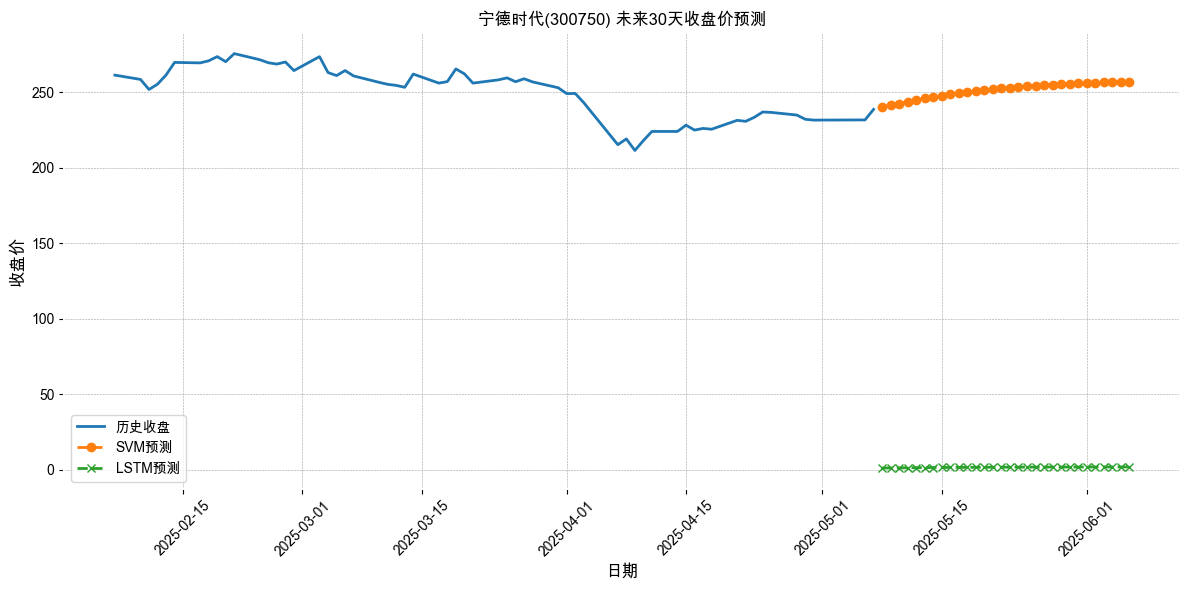

In [43]:
import pandas as pd
import akshare as ak
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import tensorflow as tf

# —— 读取情绪+股价、训练模型的部分略 —— 
# 假设此时你已有：data (含 'close' 和 'sentiment'), svm, lstm, scaler

# 预测未来30天
forecast_days = 30
window = 5
last_prices = data['close'].values[-window:].tolist()
last_sent = data['sentiment'].iloc[-1]
future_sent = [last_sent]*forecast_days

svm_future, lstm_future = [], []

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 定义 LSTM 快速预测函数
@tf.function
def lstm_predict_fn(x):
    return lstm(x)

current = last_prices.copy()
for i in range(forecast_days):
    feat = np.array(current + [future_sent[i]]).reshape(1, -1)
    feat_s = scaler.transform(feat)

    p_svm  = svm.predict(feat_s)[0]
    p_lstm = lstm_predict_fn(tf.convert_to_tensor(feat_s.reshape(1,1,-1),dtype=tf.float32))[0,0].numpy()

    svm_future.append(p_svm)
    lstm_future.append(p_lstm)

    current.pop(0)
    current.append(p_svm)

last_date    = data.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_days, freq='D')

# 绘图
plt.figure(figsize=(12,6))
# 历史
plt.plot(data.index[-60:], data['close'][-60:], label='历史收盘')
# 预测
plt.plot(future_dates, svm_future, '--o', label='SVM预测')
plt.plot(future_dates, lstm_future, '--x', label='LSTM预测')

plt.title("宁德时代(300750) 未来30天收盘价预测")
plt.xlabel("日期")
plt.ylabel("收盘价")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()